<a href="https://colab.research.google.com/github/ShinAsakawa/2015corona/blob/master/notebooks/2021_0227Foygel_Dell_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulationf for the weight-decay and sp models
- date: 2020-1105
- author: Shin Asakawa
- Origin: Foygel and Dell (2000) Models of Impaired Lexical Access in Speech Production, 
- Journal of Memory and Language 43, 182–216 (2000) doi:10.1006/jmla.2000.2716

<img src="https://github.com/project-ccap/project-ccap.github.io/blob/master/figures/2000Foygel_Dell_fig1.png?raw=truen" style="width:33%"><br/>
<div align="left" style="width:49%">
Foygell and Dell (2000) Fig. 1. オリジナルは Dell (1997) 3 つの層の結合は双方向。
上から意味層, 語彙層, 音素層。最上層の意味層で 暗く塗りつぶされているニューロンは `cat`, `dog`, `rat` で共有されていることを示す。
</div>

Dell らのモデルには解析解が存在するのではないかという疑惑がある。
Dell らと Roelofs, Levelt らも基本的な動作方程式は上式の通りである。

$$
x_{i,t+1} = (1-d) x_{i,t} + \sum_j w x_{j,t} +\mathcal{N}(x_i),
$$

$x_{i,t}$ は時刻 $t$ における $i$ 番目のニューロンの活性値，$d$ は崩壊率，$w$ は重み係数である。
正規乱数であり $a_1=0.01, a_2=0.16$ をパラメータとする次式 $x_i\sim \mathcal{N}(0, a_1^2+a_2^2x_{i,t})$ 
で与えられる。
Dell の初期の weight decay モデルでは $w$ と $d$ が系全体の挙動を定めるパラメータであった。

<!--
> ただし，Levelt, Roelofs らの WEAVER, WEAVER++, WEAVER++/ARC は決定論的動作方程式であるため，右辺最終稿の $\text{noise}$ が存在しない。
$1\le d\le0$ であるから，ノイズを無視すれば，
$$
x_{i,t} = e^{-dt},
$$
である。ノイズ項は乱数であるから，各乱数が i.i.d であると考えられるので，よく知られているとおり 2 つの確率変数 $x$ と $y$ の和の期待値と分散は
$$
E(X+Y) = E(X) + E(Y)
$$
$$
V(X+Y) = V(X) + V(Y) + \text{Cov}(X,Y)
$$
である。
-->

また $t=8$ のとき $x_{i,t=8}=10$ という，正解へのブースト (原著論文では `jolt`)がある。
$n=8$ と $n=16$ で jolt (boost) する。

- **レンマアクセス** 
猫の絵が提示されたとする。モデルの外にある視覚的プロセスが画像を識別し、猫の概念に対応する10個の意味的ノードにそれぞれ活性化の衝撃が与えられる。このときの衝撃の大きさは任意に100とし、10個のノードで分割すると、猫の意味ノードに10の衝撃が与えられることになる。
ネットワーク内にフィードバックが存在するということは、レンマアクセスの間に、`mat`, `sat`, `can` などの `cat` の音韻的隣接単語ノードが活性化されることを意味する。
これは `dog` のような意味的隣接語に加えて、共有された意味的なノードを介して活性化される。
したがって、このステップで最も活性化される単語ノードは、ターゲット語とその意味的・形式的に関連する隣接語人である。
レンマ・アクセスは、選択プロセスによって終了する。単語は、その中で最も活性化している単語ノードが選択される。

- **音素学的アクセス**
語彙検索の第二段階は、選択された単語のノードである `cat` に大きな活性化のブーストが与えられて開始される。
ブースト値は意味レベルへの最初のブーストと同様100単位である。
選択された単語へのこの大きなブーストは、非線形性が介入し、単語ノードが有用な隠れ層として機能することを可能にする。
これにより、意味層から単語形式への写像が実現される。
このブーストは、音韻的アクセスの開始時に、単語ノード `cat` をその競合単語のどれよりもはるかに活発にさせる。
`cat` へのブースト後、活性化はさらに $n$ 時間ステップ拡散する。
レンマアクセスの場合と同様、活性化は上にも下にも広がり `cat` に接続されているノード以外のノードが活性化することもある。
しかし、音素アクセス時の拡散処理の目的は `cat` の音素を取得することである。
$n$ 時間ステップを経て、最も活性化度の高い音素ノードが選択され、音韻フレームのスロットにリンクされる。
音素フレームは単語の構造を表しており、その音節の数とストレスパターン、各音節内の子音と母音の系列を表している。
本実装モデルにおける単純化では、単音節単語である，ｌ子音-母音-子音 (cvc) 単語のみを用いている。
各音素ノードは，オンセット子音と，母音と，コーダ子音 でラベル付けされる。
最も活性化度の高いオンセット，母音，コーダが選択され，フレーム内の対応するスロットに関連付けることで行われる。
`cat` の場合、/k/-オンセット, /ae/-母音, /t/-コーダのノードが選択されやすい。
モデルには 5 つのエラーカテゴリが存在する。
このエラーカテゴリは、コード化されることがあるいくつかの影響を反映してはいない。
例えば ターゲット単語の音素が誤って並べられる **言い間違いエラー**や、以前に話された単語やその音が対象語に持続的に入ってくる **保続エラー**である。
このモデルでは、スロット位置への音素の関連性を仮定しているため、音節内の音の並び替えを許容していない。

- **実装**
モデルを 非失語症患者の絵画命名検査結果に適合させ、その後、失語症患者データに再適合させる。
この実装のために、ネットワーク構造と拡散活性化パラメータの両方を指定しなければならない。
実装戦略は 3 つのフェーズからなる。
    - 第一段階: ネットワーク構造を特定し、モデルのネットワークが適用されるドメインである英語辞書の本質的な特徴を保持していることを確認する。
    - 第2段階: フィラデルフィア命名テスト（PNT）で英語の非形容詞話者をテストし、結果として得られる誤差データに適合するようにモデルをパラメータ化する。
    - 最終段階: パラメータ化されたモデルを患者データに適用する。
誤りの頻度を推定するため，非単語の頻度，すなわち生成された音列が非単語である可能性を決定した。
Dell and Reich (1981) と Best (1996) は、絵画命名研究と音声エラーから単語のセットを取り出し、各単語に含まれる 1 つの音素を別の音素で置き換えて、合法的な文字列を作成した。
これらセットに含まれる非単語の割合は 約 0.55 から 0.80 の範囲であった。
この場合、単語性とは大学レベルの辞書に掲載されていることを意味する。
この手法は、実際の単語の音素学的に合致した隣接非単語である確率を決定する。
しかし、この手法は実在する単語の隣接語を見ることになり、また、単語は音韻空間周辺に存在する傾向がある。
このため，非単語の結果のエラーの可能性を過小評価する可能性がある。
このため、非単語の誤差頻度の推定値として，最も保守的な値である $0.80$ を選択した。
また PNT の対象語に対して置換法を用いたところ、辞書基準を用いて $0.74$ の非単語が推定された。
このことから $0.80$ の値が妥当であることがわかった。

- **健常データへのフィット**
前述の近傍構造を用いて、統制群データに適合するモデルのパラメータ空間を探索した。
選択したパラメータは，データに近い誤差確率をもたらした。表は、これらのパラメータと 100,000 回の試行に基づいてシミュレートされた誤差確率を示している。
データとモデルの両方において、命名は非常に正確で、意味エラーが優勢であり、形式エラーは意味的な関係に関連してのみ存在していた。

<center>
Table 4: Nammg Data From 60 Control Participants and Simulated Probabilities

|Data source| correct | semantic | Formal | Non word | Mixed | Unrelated |
|-----------|---------|----------|--------|----------|-------|-----------|
|Controls   | .969    |.012      | .001   | .000     | .009  |  .003     |
|Simulated probabilities | .966 | .021 | .000 | .001 | .012  |  .000     |

Chosen parameters: $w=0.01$, $d=0.5$, $\text{SD1}=O.01$, $\text{SD2}=0.16$; $n=8$.
</center>


<center>
Foygel Dell (2000) table 1.<br/>

|patient|correct|semantic|formal|nonword|mixed|unrelated|
|:---|:---|:---|:---|:---|:---|:---|
|L.H. |0.69|0.03|0.07|0.15|0.01|0.02|
|DSMSG(weight=0.0057,decay=0.5)|0.69|0.07|0.06|0.14|0.01|0.03|
|I.G. |0.69|0.09|0.05|0.02|0.03|0.01|
|DSMSG(weight=0.1,decay=0.86)|0.73|0.13|0.04|0.05|0.04|0.01|
</center>

<center>
Foygel Dell (2000) table 3.<br/>

|patient|correct|semantic|formal|nonword|mixed|unrelated|
|:---|:---|:---|:---|:---|:---|:---|
|control |0.9690|0.0120|0.0010|0.0000|0.0090|0.0030|
|sp model(s=0.0698, p=0.1000)|0.9722|0.0126|0.0011|0.0001|0.0138|0.0002|
</center>    

<!--
> **Lemma access**. Assume that a picture of a cat is presented. Visual processes that are outside of the model identify the picture
and the 10 semantic nodes corresponding to the cat concept are each given a jolt of activation. 
The size of the jolt was arbitrarily set at 100, which, when divided among 10 nodes, gives a jolt of 10 to each semantic node for cat.

> The existence of feedback in the network means that during lemma access the word nodes of phonological neighbors of _cat_, such as _mat_, _sat_, or _can_, will become activated. 
This is in addition to semantic neighbors such as _dog_, which obtain activation from shared semantic nodes. 
Thus, the most activated word nodes at this step are the target and its semantic and formally related neighbors.

> Lemma access is concluded by a selection process. 
The most highly activated word node of the proper syntactic category is selected. 
During the production of a sentence, selection entails the linkage of a word to a slot in a syntactic frame. 
Frame and slot approaches to grammatical encoding in production have ample empirical support (Bock & Loebell, 1990; Garrett, 1975; Levelt, 1989; see Bock & Levelt, 1994, for a review). 
In the case of object picture naming, we assume a degenerate frame consisting of a slot for a single noun. Therefore, in our implementation of the naming task, the most highly activated noun is selected.

> **Phonological access**. The second step of lexical retrieval begins when the selected word node. _cat_, is given a large jolt of activation. 
This is also 100 units' worth, the same as the initial jolt to the semantic level. 
When a sentence is being produced, the jolt to a word occurs when the syntactic frame says that it should occur. 
In a single-word naming task. 
it occurs immediately on selection because there is only a single noun slot in the frame.[3] 

> This large jolt to the selected word is important because it introduces a nonlinearity and hence allows the word nodes to act as a useful hidden layer. 
This, in turn, allows the meaning-to-form mapping to be achieved. 
The jolt makes the word node _cat_ much more active than any of its competitors at the beginning of phonological access. 
This function of enhancing the "winner" is often carried out by lateral inhibition among competitors (e.g., Feldman & Ballard, 1982; Grossberg, 1982; Harley, 1990; McClelland & Rumelhart, 1981) or by an absolute threshold that, when crossed, boosts the activation of a node (e.g., MacKay, 1987). 
The jolt to the selected word in our model is similar to these mechanisms. 
However, we are specifically tying it to syntactic processes. 
The source of the jolt is the syntactic slot that the selected word is linked to (e.g., Berg, 1988; Dell & O'Seaghdlha, 1991; Eikmeyer & Schade, 1991; MacKay, 1982, 1987; Stemberger, 1985).

> After the jolt to _cat_, activation spreads for $n$ more time steps. 
As was true for lemma access, adivation spreads both upward and downward, and nodes other than those connected to _cat_ can become activated. 
The goal of the spreading proccess during phonological access, however, is to retrieve the phonemes of _cat_. 
After the $n$ time steps, the most highly activated phoneme nodes are selected and linked to slots in a phonological frame, a process analogous to the linking of the selected word to a syntactic slot in lemma access. 
A phonological frame represents the structure of a word --- its number of syllables and their stress pattern and the sequence of consonants and vowels within each syllable. 
Most current theories of production hypothesize that phonological access consists of the retrieval of phoneme-size units and their insertion into frame slots, although there are differences among theorists with respect to the nature or the frame (for reviews, see Levelt. 1992; Meyer & Bock, 1992; Shattack-Hufnagel, 1992). 
The evidence for phonological frames comes from speech errors (e.g., Shattuck-Hufnagel, 1979; Sternberger, 1990) and experimental studies showing that frame structures can be primed (Meijer, 1994; Romani, 1992; Sevald, Dell, & Cole, 1995).

> One simplification of the implemented model is that it only has a frame for single-syllable consonant-vowel-consonant (cvc) words. 
Each phoneme node is labeled according to whether it is an onset consonant, a vowel, or a coda consonant.
Selection consists of picking the most highly activated onset, vowel, and coda and associating them with the corresponding slots in the frame. 
In the case of _cat_, the nodes for /k/-onset, /ae/-vowel, and /t/-coda would likely be seleted. 
Thus, phonological selection is guided by categoreies, such as onset or vowel, in the same way that lemma selection is guided by syntactic categories. 
Categorical selection in phonological access is suggested by patterns of sound substitutions in phonological speech
errors (e.g., MacKay, 1970, 1972; Shattuck-Hufnagel, 1979).


> Although the model's five error categories can code most of the error responses reported in the literature, the categories do not reflect some influences that are sometimes coded. 
These influences are observed in errors in which the phonemes of the target word are misordered and errors in which previously spoken  words or their sounds perseverate into the target. 
Because of the model's assumptions about the association of phonemes to slot positions, it does not allow for the misordering of sounds within a syllable, such as cat spoken as _act_ or _tack_. 
This is probably correct for normal speech errors (e.g., Dell, 1986), but not for aphasic speakers, who, as noted earlier, do exhibit misordering within the syllable or word. 
In addition, because the model assumes that each naming attempt is independent of other attempts, perseverative effects do not occur.
In principle, a spreading activation model can account for such effects through persistence of activation or connection weight changes (Plaul & Shallice, 1993a), but we did not implement such a mechanism.

保続についても言及はしているな

> **Implementation**. 
Our goal is to fit the model to nonaphasic picture-naming data and then lesion it to fit patient data. 
For such an implementation, both the network structures and the spreading activation parameters have to be specified. 
Our strategy for implementation has three phases. 
In the first phase, we specify the network structure, making sure that the model's network preserves essential features of the domain to which it is applied, the English lexicon. 
The second phase consists of testing nonaphasic speakers of English on the Philadelphia Naming Test (PNT) and then parameterizing the model so that it fits the resulting error data. 
The chosen parameters also will have to be consistent with facts about the time course of picture naming, specifically that the activation pattern initially includes semantic, but not phonological, neighbors of the target and then later includes phonological, but not semantic, neighbors (Peterson & Savoy, in press; Schriefers et al., 1990). 
The final phase of modeling involves applying the parameterized model to patient data. 

一段落省略

> To estimate the error opportunities, we first determined the opportunities for non words (i.e., the likelihood that a legal string is a nonword). 
Dell and Reich (1981) and Best (1996) took sets of words from picture-naming studies and speech error collections and replaced a single phoneme in each word with another phoneme creating a legal string. 
The proportion of nonwords in these sets ranged from around .55 to .80, in which wordhood meant being listed in a college-level dictionary. 
This technique essentially determines the chance that phonologically legal neighbors of real words are nonwords. 
However, because it involves looking at the neighbors of real words, and words tend to clump in phonological space, it may underestimate the error opportunities for nonword outcomes. 
For this reason, we chose the most conservative value, $0.80$, as the estimated error opportunity for nonwords. 
We also used the substitution technique on the target words for the PNT and found an estimate of $0.74$ nonwords using the dictionary criterion, which made us feel reasonably comfortable with the chosen $0.80$ value.

> #### Model Fit to Control Data 
> Using the neighborhood structure described earlier, we explored the parameter space of the model to fit the control data. 
The chosen parameters led to error probabilities reasonably close to those in the data. 
Table 4 shows these parameters and the simulated error probabilities, which were based on 100,000 trials. 
In both the data and the model, naming was highly accurate, semantically related errors predominated, and formal relations were present only in conjunction with a semantic relation. 

Table 4: Nammg Data From 60 Control Participants and Simulated Probabilities

|Data source| correct | semantic | Formal | Non word | Mixed | Unrelated |
|-----------|---------|----------|--------|----------|-------|-----------|
|Controls   | .969    |.012      | .001   | .000     | .009  |  .003     |
|Simulated probabilities | .966 | .021 | .000 | .001 | .012  |  .000     |

Chosen parameters: $w=0.01$, $d=0.5$, $SD1=O.01$, $SD2=0.16$; $n=8$.
-->

# 0. 初期設定

In [ ]:
import numpy as np
import time

from numpy.random import Generator, PCG64
rng = Generator(PCG64())
#rng.standard_normal()

# 表示精度桁数の設定
np.set_printoptions(suppress=False, formatter={'float': '{:7.4f}'.format})
np.set_printoptions(suppress=False, formatter={'float': '{:6.3f}'.format})

import matplotlib.pyplot as plt
%matplotlib inline

# 事前に `!pip install japanize_matplotlib` が必要
import japanize_matplotlib

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


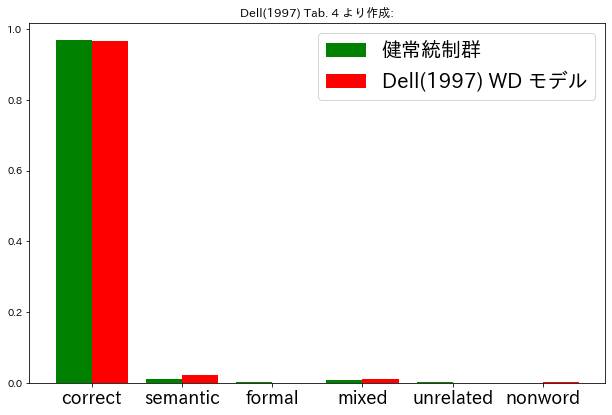

In [ ]:
fig = plt.figure(figsize=(8,5))  # 横と縦のサイズ，単位はインチ
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)

plt.title('Dell(1997) Tab. 4 より作成:')
# Dell(1997)による健常者のデータ
Dells_controls = np.array([0.9690, 0.0120, 0.0010, 0.0090, 0.0030, 0.0000])  

# Dell(1997)による WD モデルのデータ
Dells_WD = np.array([0.9660, 0.0210, 0.0000, 0.0120, 0.0000, 0.0010])  

# Foygel & Dell(2000)による SP モデルのデータ, Tab. 3 Foygel and Dell (2000)
Dells_SP = np.array([0.9722, 0.0126, 0.0011, 0.0138, 0.0002, 0.0001])  

# 横軸のラベル名
ax.set_xticklabels(['', 'correct', 'semantic','formal','mixed','unrelated', 'nonword'], fontsize=18)

ax.bar(X-0.2, Dells_controls, color='g', width=0.4, label='健常統制群')
ax.bar(X+0.2, Dells_WD, color='r', width=0.4, label='Dell(1997) WD モデル')
plt.legend(fontsize=20)
plt.show()

# 1. 必要となるパラメータの宣言

In [ ]:
# Weight-Decay モデルのパラメータ, 値は Dell らの原著論文に記載されている値を採用
Weight = 0.1  # for normal
Decay  = 0.5  # for normal

# S-P モデルのパラメータ
S_weight = 0.0698
P_weight = 0.1000
SP_decay = 0.6

Model = 'WD'
# Model = 'SP'

# ノイズパラメータ。SD1 は定常雑音，SD2 は x の大きさに依存した雑音 x ~ N(0,SD1^2+SD2^2 x)
SD1 = 0.01
SD2 = 0.16

# 外部入力を表す値，ブーストを起こす時刻
Sem_jolt = 10
Lex_jolt = 100

# Dell らのモデルは 3 層の相互活性化モデルを踏襲している
# 意味層 <---> 語彙層 <---> 音韻層
# 3 層の 2 ステップ相互活性化モデルのニューロン数
n_sem = 54 # nubmer of semantic neurons
n_lex = 6  # number of lexical neurons
n_phon = 9 # number of phonological neurons

# 3 つの層を定義
Sem = np.zeros([n_sem,], dtype=np.float)   # 意味層
Lex = np.zeros([n_lex,], dtype=np.float)   # 語彙層
Pho = np.zeros([n_phon,], dtype=np.float)  # 音韻層

Ws = np.zeros((n_sem, n_lex))
Ws= np.array([[1,1,1,1,1,1,1,1,1,1, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0, 0,0,0,0],  # cat 正解
              [0,0,0,0,0,0,0,1,1,1, 
               1,1,1,1,1,1,1,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 0,0,0,0],  # dog 意味エラー
              [0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,1,1,1, 
               1,1,1,1,1,1,1,0,0,0, 
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0, 0,0,0,0],  # mat 形態エラー
              [0,0,0,0,0,0,0,1,1,1, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,1,1,1, 
               1,1,1,1,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0, 0,0,0,0],  # rat 混合エラー
              [0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,1,1,1,1,1,1,
               1,1,1,1,0,0,0,0,0,0, 0,0,0,0],  # fog 無関連エラー
              [0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0, 
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,1,1,1,1,1,1, 1,1,1,1]  # lat 非単語
             ])
#Ws = Ws.T

# 語彙の定義
# cat(correct), dog(semantic), mat(formal), rat(mixed), log(unrelated), lat(nonword)
words = ['cat', 'dog', 'mat', 'rat', 'fog', 'lat']

# 音素の定義
phonemes = {'onset':['f', 'r', 'd', 'k', 'm'],
            'vowel':['ae', 'o'],
            'coda':['t','g']}
Onset, Vowel, Coda = slice(0,5), slice(5,7), slice(7,9)

# 語彙層と音韻層とを結ぶ結合係数行列の定義
#                               f.   r.   d.   k.   m.   ae.  o.   t.   g
phonology = {'cat': np.array([ 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # correct
             'dog': np.array([ 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # semantic error
             'mat': np.array([ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]),  # formal error
             'rat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # mixed error
             'fog': np.array([ 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # unrelated error
             'lat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0])}  # nonword
# phonology は BOW 形式なんですなー

In [ ]:
class Dell_model(object):
    def __init__(self, Model='WD', Ws=None, Wp=None, param=None, seed=None):
        
        if not seed:
            self.seed = int(time.time())
        else:
            self.seed = seed
        self.rng = Generator(PCG64(self.seed))
        
        self.sem_jolt = 10
        self.lex_jolt = 100
        self.jolt_t = 7  # カウントが 0 ベースなので t=7 (8-1) が 8 回目
        
        # ノイズパラメータ。SD1 は定常雑音，SD2 は x の大きさに依存した雑音 x ~ N(0,SD1^2+SD2^2 x)
        self.SD1 = 0.1
        self.SD2 = 0.4
        
        if param == None:
            self.param = {'WD':{'Weight':0.1,  # for normal
                                'Decay':0.5    # for normal
                               },
                          'SP':{'Decay': 0.6,
                                'S_Weight':0.0698,
                                'P_Weight':0.1000
                               }}
        else:
            self.param = param

        
        self.n_sem = 54 # nubmer of semantic neurons
        self.n_lex =  6  # number of lexical neurons
        self.n_phon = 9 # number of phonological neurons

        # 3 つの層を定義
        self.Sem = np.zeros([n_sem,], dtype=np.float)   # 意味層
        self.Lex = np.zeros([n_lex,], dtype=np.float)   # 語彙層
        self.Pho = np.zeros([n_phon,], dtype=np.float)  # 音韻層

        if Ws == None:
            self.Ws = self.init_Ws()
        else:
            self.Ws = Ws
            
        if Wp == None:
            self.Wp = self.init_Wp()
        else:
            self.Wp = Wp

        if Model == 'WD':
            self.s_weight = self.param['WD']['Weight']
            self.p_weight = self.param['WD']['Weight']
            self.decay = self.param['WD']['Decay']
        else:
            self.s_weight = self.param['SP']['Weight']
            self.p_weight = self.param['SP']['Weight']
            self.decay = self.param['SP']['Decay']
        self.Ws *= self.s_weight
        self.Wp *= self.p_weight
        return

            
    def init_Ws(self):
        return np.array([[1,1,1,1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,0,0, 
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0],             # cat 正解
                         [0,0,0,0,0,0,0,1,1,1, 1,1,1,1,1,1,1,0,0,0, 
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0],             # dog 意味エラー
                         [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,1,1,1, 
                          1,1,1,1,1,1,1,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0],             # mat 形態エラー
                         [0,0,0,0,0,0,0,1,1,1, 0,0,0,0,0,0,0,0,0,0, 
                          0,0,0,0,0,0,0,1,1,1, 1,1,1,1,0,0,0,0,0,0,
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0],             # rat 混合エラー
                         [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0,1,1,1,1,1,1,
                          1,1,1,1,0,0,0,0,0,0, 0,0,0,0],             # fog 無関連エラー
                         [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0, 
                          0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                          0,0,0,0,1,1,1,1,1,1, 1,1,1,1]              # lat 非単語
                        ], dtype=np.float)

    def init_Wp(self):
        # 語彙層と音韻層とを結ぶ結合係数行列の定義
        #                                     f.   r.   d.   k.   m.   ae.  o.   t.   g
        self.phonology = {'cat': np.array([ 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # correct
                          'dog': np.array([ 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # semantic error
                          'mat': np.array([ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]),  # formal error
                          'rat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # mixed error
                          'fog': np.array([ 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # unrelated error
                          'lat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0])}  # nonword
        # phonology は BOW 形式なんですなー
        Wp = np.zeros((n_lex, n_phon), dtype=np.float)
        for i, x in enumerate(phonology.values()):
            Wp[i] = np.copy(x)
        return Wp

        
    def initialize(self):
        return init_Wp(), init_Ws()

        
    def update(self, Sem, Lex, Pho):
        """3 層を更新式を用いて更新する"""
        Sem_next = Sem * (1. - self.decay) + np.matmul(self.Ws.T, Lex)
        Lex_next = Lex * (1. - self.decay) + np.matmul(self.Ws, Sem) + np.matmul(self.Wp, Pho)
        Pho_next = Pho * (1. - self.decay) + np.matmul(self.Wp.T, Lex)
    
        # ノイズの付加
        for x in [Sem_next, Lex_next, Pho_next]:
            # SD1 ノイズの付加
            x +=  self.rng.standard_normal(size=len(x)) * self.SD1**2
            for i, xx in enumerate(x):
                # SD2 ノイズの付加と ReLU
                xx += xx * self.rng.standard_normal() * self.SD2**2
                x[i] = max(0, xx)
        return Sem_next, Lex_next, Pho_next

    
    def one_epoch(self, verbose=False):
        n=16
        # sem_jolt=Sem_jolt, lex_jolt=Lex_jolt, jolt_t=7, verbose=False):
    
        # 各層を 0 で初期化
        self.Sem.fill(0); self.Lex.fill(0); self.Pho.fill(0)

        # 意味層での語彙表現は 10 ニューロンが 1, 他が全て 0 であることを表す全要素が 1 のベクトル
        input_vec = np.ones((1,10), dtype=np.float)
    
        self.Sem[:10] = np.copy(input_vec) * self.sem_jolt  # ターゲットである `cat` を意味層にセット
        #Sem[7:17] = np.copy(input_vec) * sem_jolt # dog にするならこの行を生かして直上行をコメントアウト

        # 更新は 16 回。原著論文では n と記載されている
        # t=8 のときブースト (jolt) を起こす
        self.Ws, self.Wp = self.init_Ws() * self.s_weight, self.init_Wp() * self.p_weight
        for tau in range(n):
            if tau == self.jolt_t:
                self.Lex[np.argmax(Lex)] = self.lex_jolt
            if verbose:
                print('tau=', tau+1, self.Lex)
            self.Sem, self.Lex, self.Pho = self.update(self.Sem, self.Lex, self.Pho)

        # 最も良く当てはまっている出力を検索
        min_v = np.finfo(self.Pho.dtype).max
        min_n = 'NG' # len(words) + 1
        dum = np.zeros_like(self.Pho)
        dum[np.argmax(Pho[Onset])] = 1.
        dum[np.argmax(Pho[Vowel])+5] = 1.
        dum[np.argmax(Pho[Coda])+5+2] = 1.
        if verbose:
            print('dum', dum)
            print('Pho', self.Pho)
        for k, v in self.phonology.items():
            _x = np.sum((v - self.Pho)**2)
            #_x = np.sum((v - dum)**2)
            if _x < min_v:
                min_n = k
                min_v = _x
        if min_n != 'cat' and verbose:
            print('{2:03d} output:{0}, Least Mean Square:{1:8.5f}'.format(min_n, min_v, i), end=", ")
            print('Pho', Pho)

        return min_n, min_v


In [ ]:
# 確認用
# フィラデルフィア絵画命名検査 PNT の図版総数が 175 枚であるため，この回数だけ繰り返す
nPNT = 175
#nPNT = 1000
#nPNT = 1  # テスト用

# 実際のシミュレーションの実施
model = Dell_model()
results = np.zeros((nPNT, len(words)), dtype=np.float)
for i in range(nPNT):
    word, val = model.one_epoch(verbose=False)
    results[i, words.index(word)] = 1.

In [ ]:
# シミュレーション結果の印字
print('Response         : [ Corr.  Sem.   For.   Mixed  Unrel. Nonword]')
print('Examples         :', words)
print('This result      :', np.mean(results, axis=0))
print('Dell1997 Tab4(WD):', Dells_WD)
print('F&D2000 Tab3(SP) :', Dells_SP)
print('Control          :', Dells_controls)
print('Parameters       : weight={0}, Decay={1}'.format(Weight, Decay))

    

Response         : [ Corr.  Sem.   For.   Mixed  Unrel. Nonword]
Examples         : ['cat', 'dog', 'mat', 'rat', 'fog', 'lat']
This result      : [ 0.67  0.00  0.00  0.33  0.00  0.00]
Dell1997 Tab4(WD): [ 0.97  0.02  0.00  0.01  0.00  0.00]
F&D2000 Tab3(SP) : [ 0.97  0.01  0.00  0.01  0.00  0.00]
Control          : [ 0.97  0.01  0.00  0.01  0.00  0.00]
Parameters       : weight=0.1, Decay=0.5


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


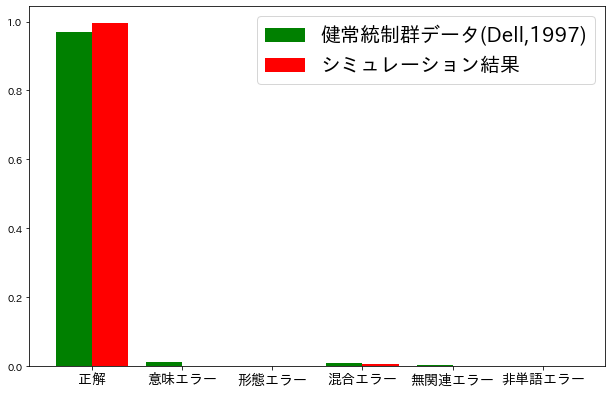

In [ ]:
# 結果の表示
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)

#ax.set_xticklabels(['', 'correct', 'semantic','formal','mixed','unrelated', 'nonword'])
ax.set_xticklabels(['', '正解', '意味エラー','形態エラー','混合エラー','無関連エラー', '非単語エラー'],fontsize=14)
ax.bar(X-0.2, Dells_controls, color='g', width=0.4, label='健常統制群データ(Dell,1997)')
ax.bar(X+0.2, np.mean(results,axis=0), color='r', width=0.4, label='シミュレーション結果')
plt.legend(fontsize=20)
plt.show()

#### The Semantic-Phonological Map
The semantic-phonological model associates patients with different values of $s$ and $f$. 
As a preliminary to constructing the map of the error patterns associated with variation in $s$ and $f$, we first sought model parameters that would fit the error data from DSMSG’s normal control speakers, allowing ourselves the freedom to examine different values of $s$ and $f$ in the context of other parameters. 
Table 3 shows the control data, the model’s fit, and the chosen values of $s$, $f$, and other parameters. 
The model, like the normal speakers, produces correct responses on 97% of the trials, and the few errors that occur are largely confined to the semantic and mixed categories.
Notice that we use a slightly higher decay rate ($q=0.6$) than DSMSG did ($q=0.5$). 
The semantic-phonological map was constructed using the same algorithm as in the previous section (see the Appendix). 
To enable the closest possible comparison with the weight-decay model, $s$ and $f$ were varied between $0.001$ and $0.1$, and the map was increased to similar size (3662 mapped points).


<div align="center">
Table 3. Error distribution $s=0.0698$, $f=0.1000$<br/>

|         |Correct |Semantic| Formal| Mixed |Unrelated|Nonword|
|:-------:|-------:|-------:|------:|------:|--------:|------:|
|  Control| 0.9690 |0.0120  | 0.0010|0.0090 |0.0030   |0.0000 |
|  S-F    | 0.9722 |0.0126  | 0.0011|0.0138 |0.0002   |0.0001 |   
    
</div>

----

ここから下は試作，考察，段階

* 提案モデルとして，絵画命名課題の反応は，最終時刻における音韻層の出力に比例した確率で応答が生起すると仮定する。
* すなわち 6 種類の反応範疇のうち，出力値に応じた確率で応答が生起すると考える。
* このため，音韻層の出力をソフトマックス関数をもちいて多項分布の確率密度に変換する。
* このように仮定することにより大量のシミュレーションを行いパラメータ空間の探索を行う必要がなくなる。
* パラメータ空間の探索の代わりに，パラメータの最適化問題として定式化可能である。
* Dell のモデルは w-d, s-p モデルとも 2 パラメータモデルであるから，これらのモデルをパラメータを推定することにする
* ソフトマックス関数の温度パラメータ $\beta$ (ボルツマン分布の逆温度)と Dell の 4 パラメータを合わせて $\theta=(\beta, w,d,s,p)^\top$ を探索する。


* Dell モデルの意味層（入力）は 54 ニューロンだが，6 で代用可能だろう。すなわち `cat`,`dog`,`rat`,`mat`,`fog`,`lat` を表す各ニューロンを仮定する。
* このように表現された意味（入力）層から語彙層 (6 ニューロン)への相関行列を考える。
* Dell モデルでは，54 個の視覚的意味入力ニューロンの重複から，類似度を擬似的に表現していた。
* 例えば，`cat` と `dog` とは 3 個 `on` ニューロンを共有している。すなわち，`cat` 画像が入力された場合，10 個のニューロンが on となる。
* このうち 3 個のニューロンは入力画像が `dog` でも on となる。
* 元論文から，入力層の総ニューロン数は 54 である。すなわち下のようなクロス集計表を得る:

|   |   |cat|   |   |
|---|---|---|---|---| 
|   |   | on|off|計 |
|dog|on |  3|  7| 10|
|   |off|  7| 37| 44|
|計 |   | 10| 44 |54|

- ここから，6 つの語彙間の相関係数行列 ($r_{\text{cat,dog}}=0.14$) を計算することが可能である。
- このようにして相関係数行列を算出した。
- 加えて，相関係数行列の各行をソフトマックス関数 $\displaystyle p(x_i)=\frac{\exp(x_i)}{\sum_{j}\exp(x_j)}$  によって変換する

In [ ]:
# 表示桁数の設定
np.set_printoptions(suppress=False, formatter={'float': '{:5.2f}'.format})

# 語彙層と音韻層とを結ぶ結合係数行列の定義
#                               f.   r.   d.   k.   m.   ae.  o.   t.   g
phonology = {'cat': np.array([ 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # correct
             'dog': np.array([ 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # semantic error
             'mat': np.array([ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]),  # formal error
             'rat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # mixed error
             'fog': np.array([ 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # unrelated error
             'lat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0])}  # nonword
# phonology は BOW 形式なんですなー
Wp = np.array([phonology[item] for item in phonology])

print('元データ Ws:\n', Ws)
print('元データ Wp:\n', Wp)

tags = list(phonology.keys())
print('R(Ws) 相関係数 意味入力層<->語彙層:\n', tags, '\n', np.corrcoef(Ws))
print('R(Wp) 相関係数 語彙層<->音韻層:\n', tags, '\n', np.corrcoef(np.array([phonology[item] for item in phonology])))
tags_ = {i:tag for i, tag in enumerate(tags)}


def softmax(x, beta=1.):
    """softmax 関数の定義
    引数
    x: np.array
    """
    if not isinstance(x, np.ndarray):
        return None

    if x.ndim == 1:
        return np.exp(beta * x)/np.exp(beta * x).sum()
    else:
        return np.array([np.exp(beta * x_)/np.exp(beta * x_).sum() for x_ in x])
    

元データ Ws:
 [[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]]
元データ Wp:
 [[ 0.00  0.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00]
 [ 0.00  0.00  1.00  0.00  0.00  0.00  1.00  0.00  1.00]
 [ 0.00  0.00  0.00  0.00  1.00  1.00  0.00  1.00  0.00]
 [ 0.00  1.00  0.00  0.00  0.00  1.00  0.00  1.00  0.00]
 [ 1.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  1.00]
 [ 0.00  1.00  0

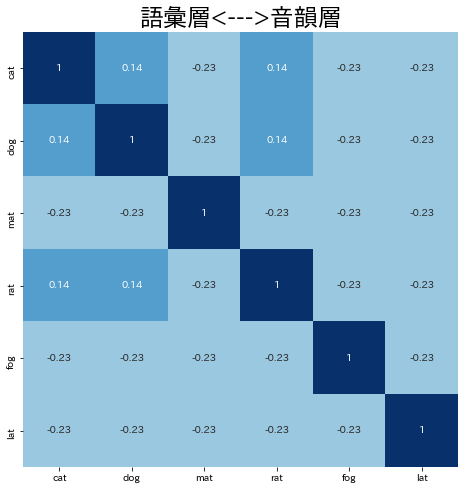

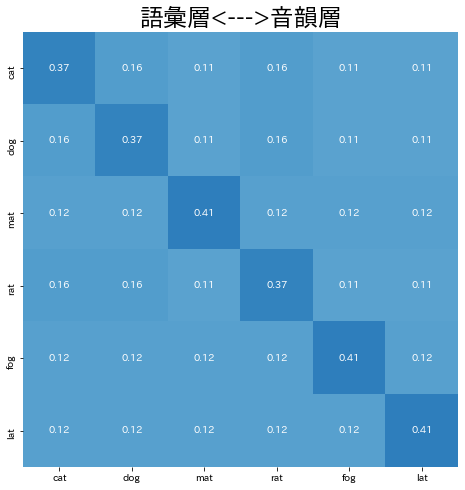

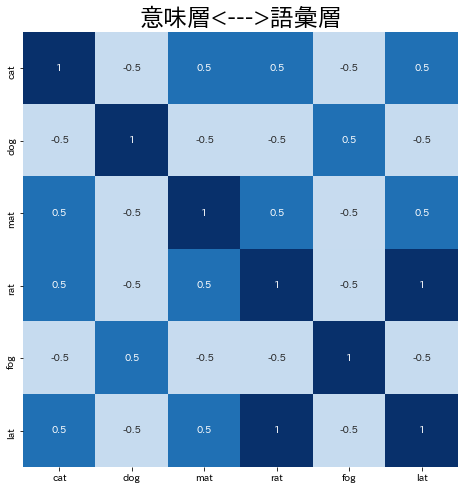

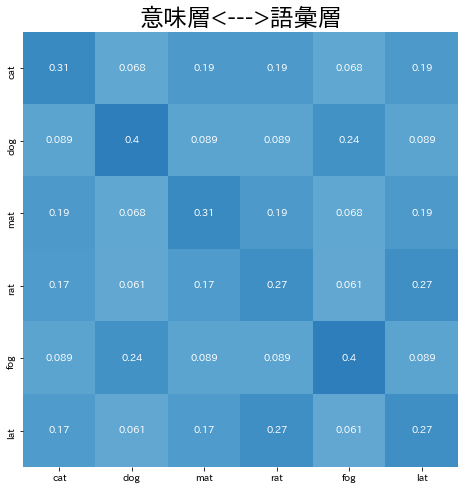

In [ ]:
# 結合係数行列を図示
import seaborn as sns
for k, data in {'語彙層<--->音韻層':Ws, '意味層<--->語彙層':Wp}.items():
    plt.figure(figsize=(8, 8))
    #plt.set_xticklabels(fontsize=14)
    sns.heatmap(np.corrcoef(data),
                annot=True, xticklabels=tags, yticklabels=tags, 
                square=True, cbar=False, vmin=-1, vmax=1, center=0, cmap='Blues')
    plt.title(k, fontsize=24)
    plt.show()

    plt.figure(figsize=(8, 8))
    sns.heatmap(softmax(np.corrcoef(data)),
                annot=True, xticklabels=tags, yticklabels=tags, 
                square=True, cbar=False, vmin=-1, vmax=1, center=0, cmap='Blues')
    plt.title(k, fontsize=24)
    plt.show()

# cmap supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
# 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
# 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r',
# 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
# 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r',
# 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 
# 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 
# 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
# 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 
# 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 
# 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r',
# 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 
# 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r',
# 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
# 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
# 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 
# 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
# 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
# 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

Dell の元論文によれば，最終的なモデルの出力結果は
`Dells_controls= array([ 0.97,  0.01,  0.00,  0.01,  0.00,  0.00])`
となるのが健常統制群のデータである。

入力は，`cat` であるから，`[1,0,0,0,0,0]` を入力層に与え，16 回繰り返しループを回して得た結果が，上記 `Dells_controls` になれば良い。
`cat` を入力ベクトル $\mathbf{x}$, `Dells_controls` を出力ベクトル $\mathbf{y}$ として，Dell の 2 つのモデル weight-decay と sp モデルのそれぞれのパラメータを
$\mathbf{\theta}=\left\{\beta,w,d,s,p\right\}$ として，Dell のネットワークに学習させることを試みる。
ここに $\beta$ はソフトマックス関数の温度パラメータである。
$w$, $d$ はそれぞれ weight-decay モデルによる weight と decay,
$s$, $p$ はそれぞれ sp モデルにけるパラメータであるとする。

時刻 16 $\tau=16$ 時の音韻層の値を尤度とみなし，ソフトマックス関数で多項分布の確率密度とみなすことにより，モデルの学習を試みる。
すなわち 時刻 $\tau$ におけるニューロン $x$ の活性値を $x_t$ と表記すれば，各時刻での活性値は次式の漸化式で与えられる:
$$
x_{t+1} = (1-d) x_{t} + \sum w x_t + z
$$

ここで $z$ は平均 0, 分散 $a_1^2 + x_t a_2^2$ に従う正規乱数 $z\sim\mathcal{N}(0,a_1^2+a_2^2 x_t)$ であるとする。

$x_{i,\tau}^{(\text{Layer})}$ を
$\text{Layer}=\left[s:\text{視覚的意味層}, l:\text{語彙層}, p:\text{音韻層}\right]$ 
を時刻 $\tau$ での層(Layer) における $i$ 番目のニューロンであるとすれば，次式を得る:

$$
\begin{array}{ll}
x_{i,t+1}^{(s)} &= (1-d)x_{i,t}^{(s)} + sw \sum_j u_{ij}^{(l)}x_j,\\
x_{i,t+1}^{(l)} &= (1-d)x_{i,t}^{(l)} + sw \sum_{j\in(s)} u_{ij}^{(s)}x_j^{(s)} + pw\sum_{j\in(p)}u_{ij}^{(p)}x_j^{(p)},\\
x_{i,t+1}^{(p)} &= (1-d)x_{i,t}^{(p)} + pw \sum_{j\in(l)} u_{ij}^{(l)}x_j^{(l)},\\
\end{array}
$$
最終的に時刻 $\tau=16$ における音韻層ニューロン $x_i^{(p)}$ の値をソフトマックス関数で多項分布の確率密度に変換することで次式のような確率を得る:
$$
p\left(x_{i,\tau=16}^{(p)}\right)=\frac{\exp\left(\beta x_{i,\tau=16}^{(p)}\right)}{\sum_j \exp\left(\beta x_{j,\tau=16}^{(p)}\right)}
= y_i
$$

ここで $u$ はソフトマックス後の $W_s$, $W_p$ の各要素である

## 学習

`Dells_controls` を教師信号 $\mathbf{t}=[0.97,  0.01,  0.00,  0.01,  0.00,  0.00]$ とする。
このとき最小化すべき目的関数(損失関数，誤差関数) $l$ を次のように定義する:

$$
l\left(y,x;\theta\right)\equiv\sum_i\left( t_i\log(y_i) + (1-t_i)\log(1-y_i)\right)
$$

$$
\frac{\partial l}{\partial y}=\sum_i\left(
\frac{t_i}{y_i}-\frac{1-t_i}{1-y_i}
\right)
= \sum_i\frac{t_i(1-y_i)-y_i(1-t_i)}{y_i(1-y_i)}
= \sum_i\frac{t_i-y_i}{y_i(1-y_i)}
$$

この $l$ を最小化する学習をニューラルネットワークの学習則に従い以下のような勾配降下法を用いて訓練する:
$$
\Delta\theta = \eta\frac{\partial l}{\partial\theta}
$$
合成関数の微分則に従って $\displaystyle\frac{\partial l}{\partial\theta}=\frac{\partial l}{\partial y}\frac{\partial y}{\partial\theta}$ である。

$\theta$ を $\beta$ とそれ以外 ($w,d,s,p$) とに分けて考える。

<!--
* $\beta$ に関して:
$$
\frac{\partial l}{\partial \beta}=\frac{\partial l}{\partial y}\frac{\partial y}{\partial\beta}
$$
-->

<!--* $\displaystyle\frac{\partial l}{\partial y}\left(t\log(y)\right) = \sum_i \frac{t_i}{y_i}$, および -->
* $\displaystyle\frac{\partial y_i}{\partial x_i} = y_i(1-y_i)\beta$, 
* $\displaystyle\frac{\partial y_i}{\partial x_j} = -y_i y_j\beta \hspace{3em}\text{ただし $i\ne j$}$
<!--* $\displaystyle\frac{\partial y_i}{\partial\beta} = y_i(1-y_i)$-->


以下のようになる:
$$
\frac{\partial l}{\partial y}=\sum_i\frac{t_i}{y_i}
$$

更に $y_i$ を $x_i$ で微分，すなわちソフトマックスの微分:
$$
\frac{\partial y_i}{\partial\beta x_i}=\frac{e^{\beta x_i}\left(\sum e^{\beta x_j}\right)-e^{\beta x_i}e^{\beta x_i}}{\left(\sum e^{\beta x_j}\right)^2}\\
=\left(\frac{e^{\beta x_i}}{\sum e^{\beta x_j}}\right)
\left(\frac{{\sum e^{\beta x_j}}-e^{\beta x_j}}{{\sum e^{\beta x_j}}}\right)\\
=y_i \left(\frac{\sum e^{\beta x_j}}{\sum e^{\beta x_i}} 
-\frac{e^{\beta x_i}}{\sum e^{\beta x_j}}\right)\\
=y_i (1-y_i)
$$

一方， $y_i$ を $x_k$ ($k\ne i$) で微分すれば，
$$
\frac{\partial y_i}{\partial\beta x_k}=-\frac{e^{\beta x_i}e^{\beta x_k}}{\left(\sum e^{\beta x_j}\right)^2}\\
=\left(\frac{e^{\beta x_i}}{\sum e^{\beta x_j}}\right)
\left(\frac{-e^{\beta x_k}}{{\sum e^{\beta x_j}}}\right)\\
=- y_i y_k
$$

以上まとめると
$$
\frac{\partial y_i}{\partial\beta x_j}=
\begin{cases}
y_i(1-y_i)&\hspace{3em}\text{if $i=j$}\\
-y_i y_j&\hspace{3em}\text{else}
\end{cases}
$$


<!--
$$
\begin{split}
\frac{\partial l}{\partial \beta} &=\frac{\partial l}{\partial p}\frac{\partial p}{\partial \beta x}\frac{\partial\beta x}{\partial \beta}\\
\frac{\partial l}{\partial \beta} &=\frac{\partial l}{\partial p}\frac{\partial p}{\partial \beta x}x
\end{split}
$$
-->

$$
\begin{split}
\frac{\partial l}{\partial \beta} &= \sum_i \frac{\partial l}{\partial p_i}\frac{\partial p_i}{\partial\beta x}\frac{\partial\beta x}{\partial \beta}\\
&=\sum_i \frac{\partial l}{\partial p_i}\sum_j\frac{\partial p_i}{\partial \beta x_j}\frac{\partial\beta x_j}{\partial\beta}\\
&=\sum_i\frac{t_i-p_i}{p_i(1-p_i}\sum_j\frac{\partial p_i}{\partial \beta x_j}\\
&=\sum_i\frac{t_i-p_i}{p_i(1-p_i)}\sum_jp_i\left(\delta_{ij}-p_j\right)x_j\\
\end{split}
$$
ただし，$\delta_{ij}$ は Kronecker のデルタである。

更に，各個のパラメータについて微分することを考える。
Dell らのモデルでは次式のような漸化式が用いられた:
$$
x_{t+1} = (1-d)x_{t} + \sum w x_{t} + z,
$$

ここで $z\sim\mathcal{N}\left(0,a_1^2 + a_2^2x_{t}\right)$ である。

提案モデルでは，類似性指標から算出した結合係数 $\left\{u_{ij}\right\}=U$ が存在するので，以下のように書き換える:

$$
\begin{split}
x_{t+1}^{(S)} &= (1-d)x_{t}^{(S)} + s w\, U_{sl}^\top x_{t}^{(L)} + z\left(x_t^{(S)}\right),\\
x_{t+1}^{(L)} &= (1-d)x_{t}^{(L)} + s w\, U_{sl} x_{t}^{(S)} + p w\, U_{lp}^\top x_{t}^{(P)} + z\left(x_t^{(L)}\right),\\
x_{t+1}^{(P)} &= (1-d)x_{t}^{(P)} + p w\, U_{lp}^\top x_{t}^{(S)} + z\left(x_t^{(P)}\right),\\
\end{split}
$$

従って, $\theta=\left(w, d, s, p\right)$ の各要素について上式を微分する。

$$
\frac{\partial x_{t+1}^{(S)}}{\partial\theta} =
\left(
\begin{array}{l}
\frac{\partial x_{t+1}^{(S)}}{\partial w}\\
\frac{\partial x_{t+1}^{(S)}}{\partial d} \\
\frac{\partial x_{t+1}^{(S)}}{\partial s}\\
\frac{\partial x_{t+1}^{(S)}}{\partial p}
\end{array}
\right)
=
\left(
\begin{array}
sU_{sl}^\top x_t^{(L)}\\
            - x_t^{(S)}\\
 wU_{sl}^\top x_t^{(L)}\\
 0
\end{array} 
\right)
$$

$$
\frac{\partial x_{t+1}^{(L)}}{\partial\theta} =
\left(
\begin{array}{l}
\frac{\partial x_{t+1}^{(L)}}{\partial w} \\
\frac{\partial x_{t+1}^{(L)}}{\partial d} \\
\frac{\partial x_{t+1}^{(L)}}{\partial s} \\
\frac{\partial x_{t+1}^{(L)}}{\partial p}\\
\end{array}
\right)=
\left(\begin{array}{l}
sU_{sl} x_t^{(S)} + pU_{lp}^\top x_t^{(P)}\\
- x_t^{(L)}\\
wU_{sl} x_t^{(S)}\\
wU_{lp}^\top x_t^{(P)}
\end{array}
\right)
$$

および

$$
\frac{\partial x_{t+1}^{(P)}}{\partial\theta} =
\left(
\begin{array}{l}
\frac{\partial x_{t+1}^{(P)}}{\partial w} \\
\frac{\partial x_{t+1}^{(P)}}{\partial d} \\
\frac{\partial x_{t+1}^{(P)}}{\partial s} \\
\frac{\partial x_{t+1}^{(P)}}{\partial p}\\
\end{array}
\right)=
\left(
\begin{array}{l}
pU_{lp}^\top x_t^{(S)}\\
- x_t^{(P)}\\
0\\
wU_{lp}^\top x_t^{(S)}
\end{array}
\right)
$$
<!--
- $\frac{\partial x_{t+1}^{(S)}}{\partial w} = sU_{sl}^\top x_t^{(L)}$
- $\frac{\partial x_{t+1}^{(S)}}{\partial d} =            - x_t^{(S)}$
- $\frac{\partial x_{t+1}^{(S)}}{\partial s} = wU_{sl}^\top x_t^{(L)}$
- $\frac{\partial x_{t+1}^{(S)}}{\partial p} = 0$

- $\frac{\partial x_{t+1}^{(L)}}{\partial w} = sU_{sl} x_t^{(S)} + pU_{lp}^\top x_t^{(P)}$
- $\frac{\partial x_{t+1}^{(L)}}{\partial d} =            - x_t^{(L)}$
- $\frac{\partial x_{t+1}^{(L)}}{\partial s} = wU_{sl} x_t^{(S)}$
- $\frac{\partial x_{t+1}^{(L)}}{\partial p} = wU_{lp}^\top x_t^{(P)}$

- $\frac{\partial x_{t+1}^{(P)}}{\partial w} = pU_{lp}^\top x_t^{(S)}$
- $\frac{\partial x_{t+1}^{(P)}}{\partial d} =            - x_t^{(P)}$
- $\frac{\partial x_{t+1}^{(P)}}{\partial s} = 0$
- $\frac{\partial x_{t+1}^{(P)}}{\partial p} = wU_{lp}^\top x_t^{(S)}$
-->

これらを用いて
$$
\frac{\partial l}{\partial\theta}=\sum_i\frac{\partial l}{\partial p_i}\sum_j\frac{\partial p}{\partial x_j}\frac{\partial x_j}{\partial\theta}
$$
から以下の更新式により学習を行う:
$$
\Delta\theta = -\eta\frac{\partial l}{\partial\theta},
$$
ここで $\eta$ は学習係数である。

In [ ]:
# ロジスティックシグモイド関数の定義
sigmoid = lambda x: 1/(1+np.exp(-x))

def dell_update(Sem, Lex, Pho, f=None, w=0.1, d=0.5, s=1.0, p=1.0, a1=0.1, a2=0.4):
    """Dell の 3 層相互活性化モデルの更新式
    
    arguments:
    - Sem: np.array
        意味層ニューロンのベクトル
    - Lex: np.array
        語彙層ニューロンのベクトル
    - Pho: np.array
        音韻層ニューロンベクトル
    - d: float
        崩壊率パラメータ
    - w: float
        重みパラメータ
    - s: float
        意味層と語彙層との結合係数パラメータ
    - p: float
        語彙層と音韻層との結合係数パラメータ
    - a1: float
        雑音パラメータ $a_1^2=0.1$
    - a2: float
        雑音パラメータ $a_2^2=0.4$
    - output_f: function
        出力関数
        指定しなければ変換せずに値を出力
    
    return:
    - Sem_next: np.array
        次刻の意味層ベクトル
    - Lex_next: np.array
        次刻の語彙層ベクトル
    - Pho_next: np.array
        次刻の音韻層ベクトル
    """
    
    #Sem_next = Sem * (1 - d) + np.matmul(P_ws.T * w * s, Lex)
    #Lex_next = Lex * (1 - d) + np.matmul(P_ws * w * s, Sem) + np.matmul(P_wp * w * p, Pho)
    #Pho_next = Pho * (1 - d) + np.matmul(P_wp.T * w * p, Lex)
    Sem_next = Sem * (1 - d) + np.matmul(P_ws * w * s, Lex)
    Lex_next = Lex * (1 - d) + np.matmul(P_ws.T * w * s, Sem) + np.matmul(P_wp.T * w * p, Pho)
    Pho_next = Pho * (1 - d) + np.matmul(P_wp * w * p, Lex)
    
    #return Sem_next, Lex_next, Pho_next

    # ノイズの付加
    for x in [Sem_next, Lex_next, Pho_next]:
        # SD1 ノイズの付加
        x +=  rng.standard_normal(size=len(x)) * a1**2
        for i, xx in enumerate(x):
            # SD2 ノイズの付加と ReLU
            xx += xx * rng.standard_normal() * a2**2
            x[i] = max(0, xx)
            
    if f == None:
        return Sem_next, Lex_next, Pho_next        
    else:
        return f(Sem_next), f(Lex_next), f(Pho_next)


In [ ]:
R_ws = np.corrcoef(Ws)
R_wp = np.corrcoef(np.array([phonology[item] for item in phonology]))

P_ws = softmax(R_ws)
P_wp = softmax(R_wp)

rng = Generator(PCG64())

def init_neurons():
    n_sem, n_lex, n_phon = 6, 6, 6
    Sem = np.zeros([n_sem,], dtype=np.float)  # 意味層
    Lex = np.zeros([n_lex,], dtype=np.float)  # 語彙層
    Pho = np.zeros([n_phon,], dtype=np.float) # 音韻層
    Sem[0] = 1.  # すなわち cat 画像が入力されたことを意味する
    return Sem, Lex, Pho

Sem, Lex, Pho = init_neurons()
for tau in range(16):
    Sem, Lex, Pho = dell_update(Sem, Lex, Pho, d=0.1, w=0.1, a1=0.1, a2=0.4, f=np.tanh)
    #Sem, Lex, Pho = dell_update(Sem, Lex, Pho, d=0.1, w=0.1, a1=0.1, a2=0.4, f=sigmoid)
    print(tau, Sem, Lex, Pho)

#print(softmax(Pho, beta=1861))

0 [ 0.76  0.00  0.00  0.00  0.00  0.02] [ 0.03  0.02  0.00  0.01  0.03  0.03] [ 0.00  0.01  0.00  0.00  0.00  0.00]
1 [ 0.60  0.01  0.02  0.01  0.00  0.02] [ 0.05  0.03  0.01  0.02  0.02  0.04] [ 0.00  0.02  0.00  0.01  0.00  0.01]
2 [ 0.48  0.01  0.04  0.01  0.01  0.02] [ 0.05  0.05  0.02  0.02  0.02  0.06] [ 0.01  0.01  0.01  0.01  0.00  0.01]
3 [ 0.47  0.01  0.04  0.03  0.00  0.02] [ 0.06  0.06  0.01  0.03  0.02  0.08] [ 0.00  0.00  0.01  0.01  0.00  0.01]
4 [ 0.41  0.03  0.04  0.02  0.02  0.04] [ 0.07  0.09  0.02  0.03  0.03  0.08] [ 0.02  0.01  0.01  0.02  0.00  0.00]
5 [ 0.38  0.02  0.06  0.01  0.01  0.04] [ 0.09  0.08  0.02  0.02  0.03  0.08] [ 0.01  0.02  0.01  0.02  0.00  0.00]
6 [ 0.37  0.03  0.05  0.02  0.02  0.03] [ 0.11  0.09  0.04  0.02  0.04  0.05] [ 0.01  0.03  0.02  0.02  0.00  0.00]
7 [ 0.34  0.01  0.05  0.01  0.01  0.03] [ 0.14  0.09  0.04  0.03  0.04  0.05] [ 0.02  0.02  0.02  0.02  0.02  0.02]
8 [ 0.33  0.00  0.03  0.01  0.03  0.04] [ 0.12  0.09  0.06  0.03  0.03  

In [ ]:
class optimize_beta():
    """Optimize the value of the thermal paramter with softmax
    ソフトマックス関数により多項分布の確率密度に変換した値から
    損失関数を算出し，その損失間数値に基づいて勾配降下法に従って温度パラメータ最適化を行う
    ただし beta は逆温度である。1/beta が実際の温度
    """
    
    def __init__(self, teacher, data, beta_init=10., iter_max=10**5, lr=0.5, interval=None, verbose=True):
        """
        - 引数
        teacher: np.array
            教師信号
        data: np.array
            元データ
        beta_init: float
            ソフトマックス関数を計算する際に用いる温度パラメータの初期値
        iter_max: int
            繰り返し回数の上限値
        lr: float
            学習係数
        interval: int
            途中結果を出力する際の感覚
        verbose: bool
            True なら途中結果の冗長な出力を印字する
            デフォルトでは True
        """
        self.teacher = teacher
        self.data = data
        self.beta = beta_init
        self.iter_max = iter_max
        self.lr = lr
        if interval == None:
            # interval が定義されていなければ設定する
            self.interval = iter_max * 10**-1
        if verbose == None:
            self.verbose = False
        else:
            self.verbose = True
        self.epsilon = 0.0001
        return


    def __call__(self):
        for i in range(self.iter_max):
            pred = self.softmax(self.data, beta=self.beta)  # 予測値
            loss, delta_p, delta = self.loss_f(self.teacher, pred, self.data)  # 損失関数値と誤差
            self.beta += self.lr * loss  # 誤差の更新
            if self.verbose and i % (self.interval) == 0: 
                # 途中結果の出力
                print('t:{2:07d} beta:{0:8.3f} loss:{1:.4f}'.format(self.beta,loss,i), end="")
                print(' pred-teacher:{}'.format(delta))

        # 平均自乗誤差の計算
        mse = (delta**2).sum()/delta.shape[0]
        return self.beta, [loss, pred, mse]
    

    @staticmethod
    def softmax(x, beta=1.):
        """softmax 関数
        - 引数
        x: np.array
            データベクトル
        beta: float
            温度パラメータ
        
        - 戻り値
            ソフトマックス変換後のベクトル
        """
        if not isinstance(x, np.ndarray):
            return None

        if x.ndim == 1:
            return np.exp(x * beta)/(np.exp(x * beta).sum())
        else:
            return np.array([np.exp(xi * beta)/(np.exp(xi * beta).sum()) for xi in x])


    def loss_f(self, teacher, pred, data):
        """
        損失関数値の計算
        - 引数
        teacher: np.array
            教師信号ベクトル
        pred: np.array
            予測値ベクトル
        data: np.array
            ソフツマックス変換前の元データ
            
        - 戻り値
        loss: float
            損失関数の値
        """
        epsilon = self.epsilon
        delta = teacher - pred
        #loss = (delta/((1-pred) + epsilon) * (len(teacher)-2) * data).sum()
        delta_p = ((delta) / ((1-pred) + epsilon)) * data * (len(teacher)-2)
        #delta_p = ((delta) / ((1-pred) + epsilon)) / (data * (len(teacher)-2))
        #loss = np.dot(delta_p.T, delta_p)
        loss = delta_p.sum()
        return loss, delta_p, delta


teacher = np.copy(Dells_controls)
#print(teacher, softmax(Pho, beta=1851.))
#print(optimize_beta(teacher, Pho))
#print(optimize_beta(teacher, Pho, beta_init=5 * 10**0))
#optimize_beta(teacher, Pho, beta_init=1861)
#dell_model = optimize_beta(teacher, Pho)
#dell_model()
#print(optimize_beta(teacher, Pho).__call__())
print(optimize_beta(teacher, Pho, iter_max=10 ** 4)())
#print(optimize_beta(teacher, Pho, beta_init=300).__call__())
#print(optimize_beta(teacher, Pho, beta_init=300, verbose=None).__call__())


t:0000000 beta:   9.986 loss:-0.0283 pred-teacher:[ 0.79 -0.12 -0.14 -0.13 -0.11 -0.29]
t:0001000 beta:   7.401 loss:-0.0002 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0002000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0003000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0004000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0005000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0006000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0007000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0008000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
t:0009000 beta:   7.382 loss:-0.0000 pred-teacher:[ 0.79 -0.13 -0.15 -0.14 -0.12 -0.26]
(7.382266987034936, [-8.604228440844963e-16, array([ 0.18,  0.14,  0.15,  0.14,  0.13,  0.26]), 0.12789216563613043])


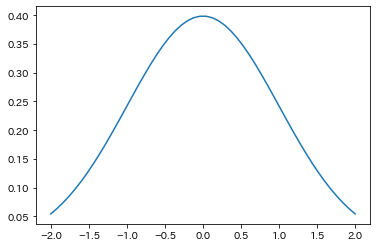

In [ ]:
# Dell のモデルの特徴である

def gauss(x, v=1.):
    y = 1./np.sqrt(2 * np.pi * v) * np.exp(-0.5 * (x **2/v))
    return y

gauss_ = lambda x, m=0, v=1.: 1/np.sqrt(2*np.pi*v) * np.exp(-0.5*(x-m)**2/v)
x = np.linspace(-2,2)
plt.plot(x,gauss_(x,m=0,v=1))
#print(gauss_(np.linspace(-2,2)))

In [ ]:
def dell_noise(x, a1=0.1, a2=0.4):
    z = a1 + a2 * np.abs(x)
    return gauss(x,v=z)

x = np.linspace(-2,2)
y = gauss(x)
d0 = dell_noise(x)

plt.figure(figsize=(8,6))
plt.plot(x, y, c='black', label="Gaussian noise $\sim N(0,1^2)$")
plt.plot(x,d0, c='green', label="Dell ノイズ $\sim N(0,a_1+a_2x)$")
#plt.plot(x,x+d0, c='pink', label="x + Dell ノイズ $\sim N(0,a_1+a_2x)$")
plt.legend(fontsize=12)
plt.show()

$$
\begin{split}
S_{t+1} &= (1-d)S_t + w (L_t + P_t) + z\\
S_{t+2} &= (1-d)S_{t+1} + w(L_{t+1}+P_{t+1}) + z\\
&=(1-d)\left\{(1-d)s_t + (1-d)w(L_{t}+P_{t}) + (1-d)z\right\}  + w(L_{t+1}+P_{t+1})+z\\
\end{split}
$$


$$
\begin{split}
L_{t+1} &= (1-d)L_{t} + w\left(S_{t}+P_{t}\right) + z\\
L_{t+2} &= (1-d)L_{t+1} + w\left(S_{t+1}+P_{t+1}\right) + z\\
&=(1-d)^2L_{t} + (1-d)^{2-1}w^1\left(S_t+P_t)\right)
\end{split}
$$

L_{t+2} &= (1-d)L_{t+1} + w(S_{t+1}+P_{t+1}\right) + z\\


In [ ]:
print(Pho)
for beta in [1, 0.1, 0.01, 10, 100]:
    print(softmax(Pho,beta=beta))
print(Pho)


In [ ]:
# BPTT を用いて，w, d, s, p の各パラメータを更新するため
# 各ニューロンの履歴を保存
tS, tL, tP = [], [], []
Sem, Lex, Pho = init_neurons()

for tau in range(16):
    print(tau, Sem, Lex, Pho)
    _Sem, _Lex, _Pho = dell_update(Sem, Lex, Pho, d=0.1, w=0.1, a1=0.1, a2=0.4, f=np.tanh)
    tS.append(_Sem), tL.append(_Lex), tP.append(_Pho)
    Sem, Lex, Pho = _Sem, _Lex, _Pho
    #Sem, Lex, Pho = dell_update(Sem, Lex, Pho, d=0.1, w=0.1, a1=0.1, a2=0.4, f=sigmoid)

np.array(tP).shape
#dell_update(Sem, Lex, Pho)

In [ ]:
class Dell_model():
    """Optimization for the Foygell and Dell model's parameter vector.
    ソフトマックス関数により多項分布の確率密度に変換した値から
    損失関数を算出し，その損失間数値に基づいて勾配降下法に従って各パラメータ最適化を行う
    ただし beta は逆温度である。1/beta が実際の温度
    
    $\beta$ に加えて，$\theta=(w, d, s, p)$ についても $\partial l/\partial\theta$ を用いて
    更新する
    """
    
    def __init__(self, teacher, data, beta_init=10., iter_max=10**5, lr=0.5, interval=None, verbose=True):
        """
        - 引数
        teacher: np.array
            教師信号
        data: np.array
            元データ
        beta_init: float
            ソフトマックス関数を計算する際に用いる温度パラメータの初期値
        iter_max: int
            繰り返し回数の上限値
        lr: float
            学習係数
        interval: int
            途中結果を出力する際の感覚
        verbose: bool
            True なら途中結果の冗長な出力を印字する
            デフォルトでは True
        """
        self.teacher = teacher
        self.data = data
        self.beta = beta_init
        self.iter_max = iter_max
        self.lr = lr
        if interval == None:
            # interval が定義されていなければ設定する
            self.interval = iter_max * 10**-1
        if verbose == None:
            self.verbose = False
        else:
            self.verbose = True
        self.epsilon = 0.0001
        return


    def __call__(self):
        pred = self.softmax(self.data, beta=self.beta)  # 予測値
        loss, delta_p, delta = self.loss_f(self.teacher, pred, self.data)  # 損失関数値と誤差
        self.beta += self.lr * loss  # 誤差の更新
        return self.beta, delta, [loss, pred]
    
    def fit(self):
        for i in range(self.iter_max):
            self.beta, delta, [loss, pred] = self.__call__()
            if self.verbose and i % (self.interval) == 0: 
                # 途中結果の出力
                print('t:{2:07d} beta:{0:8.3f} loss:{1:.4f}'.format(self.beta,loss,i), end="")
                print(' pred-teacher:{}'.format(delta))
        # 平均自乗誤差の計算
        mse = (delta**2).sum()/delta.shape[0]
        return self.beta, [loss, pred, mse]
            

    @staticmethod
    def softmax(x, beta=1.):
        """softmax 関数
        - 引数
        x: np.array
            データベクトル
        beta: float
            温度パラメータ
        
        - 戻り値
            ソフトマックス変換後のベクトル
        """
        if not isinstance(x, np.ndarray):
            return None

        if x.ndim == 1:
            return np.exp(x * beta)/(np.exp(x * beta).sum())
        else:
            return np.array([np.exp(xi * beta)/(np.exp(xi * beta).sum()) for xi in x])


    def loss_f(self, teacher, pred, data):
        """
        損失関数値の計算
        - 引数
        teacher: np.array
            教師信号ベクトル
        pred: np.array
            予測値ベクトル
        data: np.array
            ソフツマックス変換前の元データ
            
        - 戻り値
        loss: float
            損失関数の値
        """
        epsilon = self.epsilon
        delta = teacher - pred
        g_delta = ((delta) / ((1-pred) + epsilon)) * data * (len(teacher)-2)
        # 上式，最終項の -2 は，式を展開すると出てくる定数であって，マジックナンバーではない
        loss = g_delta.sum()
        return loss, g_delta, delta


teacher = np.copy(Dells_controls)
beta, [loss, pred, mse] = Dell_model(teacher, tP[-1], iter_max=10 ** 4).fit()
print(pred)

In [ ]:
print(teacher)
print(pred)

In [ ]:
#print(tP[-1], teacher)
data = tP[-1]
pred = softmax(data, beta=180)
#print(pred)
delta = teacher - pred
epsilon = 0.0001
delta_p = ((delta) / ((1-pred) + epsilon)) * data * (len(teacher)-2)
#delta_p = ((delta) / ((1-pred) + epsilon)) / (data * (len(teacher)-2))
#loss = np.dot(delta_p.T, delta_p)
loss = delta_p.sum()
print(delta_p, loss)

In [ ]:
targets = ['cat', 'dog', 'rat', 'mat', 'lat']
for target in targets:
    ft.get_nearest_neighbors(target)

In [ ]:
# http://python3.codes/neural-network-python-part-1-sigmoid-function-gradient-descent-backpropagation/
#   XOR.py-A very simple neural network to do exclusive or.
import numpy as np
 
epochs = 5000        # Number of iterations
nI, nH, nO = 2, 3, 1
 
Inp = np.array([[0,0], [0,1], [1,0], [1,1]]).T
Teach = np.array([ [0],   [1],   [1],   [0]]).T

sigmoid = lambda x: 1/(1+np.exp(-x))
d_sigmoid = lambda x: x * (1-x)

f = sigmoid
grad_f = d_sigmoid

#f = np.tanh
grad_tanh = lambda x: 1 - x * x

W1 = np.random.uniform(size=(nH, nI))
W2 = np.random.uniform(size=(nO, nH))
 
for i in range(epochs):
    Hid = f(np.dot(W1, Inp))            # hidden results
    Out = f(np.dot(W2, Hid))            # output results
    Err = Teach - Out                   # how much we missed
    dE = Err * grad_f(Out)              # delta Out
    dH = np.dot(W2.T, dE) * grad_f(Hid) # delta Hid
    W2 +=  np.dot(dE, Hid.T)            # update output weights
    W1 +=  np.dot(dH, Inp.T)            # update hidden weights
     
print(Out)                # what have we learnt?
